In [1]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from pybatteryid import ModelStructure
from pybatteryid.utilities import invert_voltage_function, analyze_dataset, load_model_from_file
from pybatteryid.plotter import plot_time_vs_current, plot_time_vs_voltage, plot_time_vs_temperature

from data import helper

### Example 3.2. Temperature-dependent Model *Validation* for an NMC Battery

This file contains an example to identify battery models for a 2.85 Ah NMC battery. See [X] for more details.

#### A. Initialize model structure

In [ ]:
# The NMC battery being modelled has the capacity around
# 2.85 Ah. The exact value has been calculated by coulomb-counting
# during GITT experiment. Note that the capacity is in Coulombs.
battery_capacity = 10344.169
sampling_period = 1

model_structure = ModelStructure(battery_capacity, sampling_period)

#### B. Load EMF data

In [3]:
emf_data = helper.load_npy_datasets('data/nmc_with_temperature/gitt_data.npy')
#
model_structure.add_emf_function({'soc_values': emf_data['soc_values'],
                                  'voltage_values': emf_data['voltage_values'],
                                  'dVdT_values': emf_data['dVoltage_dTemperature_values'],
                                  'reference_temperature_value': emf_data['reference_temperature_value']})

#### C. Load validation dataset

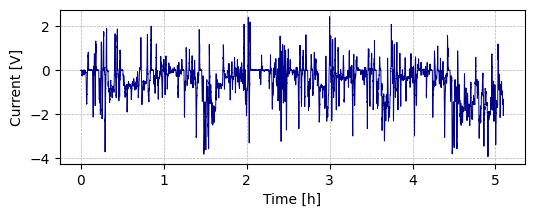

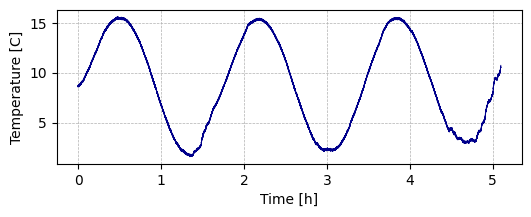

In [4]:
# Possible options: "cold", "normal" and "hot"
kind = 'cold'
dataset = helper.load_npy_datasets(f'data/nmc_with_temperature/validation_data_{kind}.npy')
#
plot_time_vs_current([(dataset['time_values'] / 3600, dataset['current_values'])],
                     units=('h', 'V'), colors=['darkblue'])
plot_time_vs_temperature([(dataset['time_values'] / 3600, dataset['temperature_values'])],
                     units=('h', 'C'), colors=['darkblue'])

We determine the initial SOC for the above dataset by inverting the EMF function.

In [5]:
initial_soc = invert_voltage_function(model_structure._emf_function,
                                      dataset['voltage_values'][0],
                                      dataset['temperature_values'][0])

In [6]:
dataset['initial_soc'] = initial_soc
analyze_dataset(dataset, battery_capacity, sampling_period, model_structure._emf_function)

                 Dataset analysis                  
┌────────────────────────────┬────────────────────┐
│ Number of samples          │ 18351              │
│ Experiment time [s], [h]   │ 18350.000, 5.097   │
│ Extracted charge [C], [Ah] │ 9308.223, 2.58562  │
│ Initial voltage [V]        │ 4.19417            │
│ Voltage range [V]          │ (2.51769, 4.24255) │
│ SOC range [%]              │ (9.91, 99.89)      │
│ Temperature range [°C]     │ (1.59, 15.60)      │
└────────────────────────────┴────────────────────┘

We prepare the input profile that will be simulated using the identified model.

In [7]:
# To perform fair comparison, we provide same number of initial
# voltage values to each model. For example, the model with n=4
# requires four initial voltage values. If n=4 is the largest model
# order to be investigated, then we provide four initial values to all
# models, that is, n=1,2,3,4. Note that such consideration may not have
# significant impact on the actual comparison, but is legit in principle.
no_of_initial_values = 4
# 
current_profile = {'initial_soc': initial_soc,
                   'time_values': dataset['time_values'],
                   'current_values': dataset['current_values'],
                   'temperature_values': dataset['temperature_values'],
                   'voltage_values': dataset['voltage_values'][:no_of_initial_values]}

#### D. Load model

In [8]:
model_file_name = "model_n,l=1,1"
model = load_model_from_file(f'results/nmc_with_temperature/{model_file_name}.npy')

#### E. Add basis functions

In [9]:
model_structure.add_basis_functions(model.basis_function_strings)

#### F. Simulate output voltage

In [10]:
voltage_simulated = model_structure.simulate(model, current_profile)

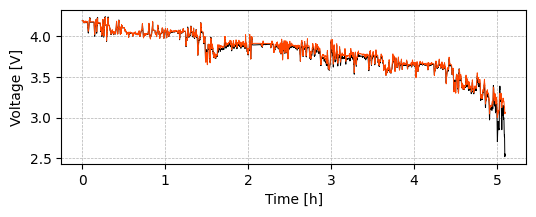

In [11]:
#
plot_time_vs_voltage([(dataset['time_values'] / 3600, dataset['voltage_values']), (dataset['time_values'] / 3600, voltage_simulated)],
                     units=('h', 'V'), colors=['k', 'orangered'])

#### G. Error analysis

In [12]:
# We find error values for the whole region
rmse = root_mean_squared_error( voltage_simulated[no_of_initial_values:], dataset['voltage_values'][no_of_initial_values:] )
mae = mean_absolute_error( voltage_simulated[no_of_initial_values:], dataset['voltage_values'][no_of_initial_values:] )

print(f"The errors are given as: (RMSE, MAE) = ({rmse * 1e3:.2f} mV, {mae * 1e3:.2f} mV)")

The errors are given as: (RMSE, MAE) = (35.82 mV, 19.17 mV)
